In [2]:
import pandas as pd
  # 데이터 처리 모듈

import numpy as np
import math
import missingno as msno
from scipy.stats import norm
  # 행렬, 선형대수 등 통계 연산 모듈

from google.colab import drive
drive.mount("/content/drive")

import seaborn as sns 
import matplotlib.pyplot as plt
  # 데이터 시각화 모듈

from typing import *
  # 타입 어노테이션 모듈(dynamic -> static)

from sklearn.preprocessing import *
from sklearn.decomposition import *
from sklearn.feature_selection import *
from sklearn.impute import *

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor

# !pip install mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

Mounted at /content/drive


### 1.데이터 분석 문제의 소재

* 온라인 커머스 플랫폼 DS로 취직한 당신의 첫 프로젝트
* 작년 대히트였던 배송비 무료 쿠폰 이벤트 시즌2 진행
* 비상장기업이었던 작년과 달리 올해는 IPO공개 후 상장하여 좀 더 스마트하게 쿠폰을 뿌리고자 하는 경영진
* 어떻게 쿠폰을 지급하고 이벤트를 진행할 것인가.

### 2.SY's Q.와 코드북

* **진정으로 흥미롭고 다른 사람들에게 가치를 더할 것이라고 생각하는 것인지 확인하는 것**
* 나이, 성별, 지역에 따른 군집 사이에 checkout, monthly_spend, shipping_fee, coupon, subscriber변수에 대한 통계적으로 유의미한 차이가 있는지 검토

| 고객 | 비회원(guest) / 일반 회원, 연간(유료)회원으로 구매 가능 |  |
| --- | --- | --- |
|  | 연간 회원(subscriber) | 무조건 배송비 무료 |
|  | 비회원(guest) / 일반 회원 | 일정 금액 이상 구매 시 배송비 무료 |
| 배송비 무료 금액 | 배송지역에 따라 다름 | 도서산간 / 해외 등 |
| 해외 배송비 | 배송량에 따라 상이 |  |
| 배송비 무료 쿠폰 정책 | 배송비가 있고 배송비 무료 쿠폰을 보유한 경우 자동 적용 후 소멸 | 1회만 사용가능 |

| feature | type | details |
| --- | --- | --- |
| age | integer | 행사 당시 유저 나이 |
| basket | float | 장바구니 총액(단위:천 원) |
| checkout | boolean(TF) | 결제(최종 구매) 여부 |
| region | string(object) | 배송지역 코드 |
| coupon | boolean | 배송비 무료 쿠폰 보유 여부 |
| gender | string | 유저성별 M F |
| monthly_spend | float | 행사 당시 월평균 결제금액(단위: 천 원) |
| shipping_fee | float | 배송비 |
| subscriber | boolean | 연간 회원 여부 |
| tenure | integer | 행사 당시 유저 가입 기간(단위: 월) |

### 3.기본적인 의문점 탐구 → 연습문제

* 배송지역별 배송료 무료 금액의 적용 전후?
* 쿠폰 적용 전후?
* 연간 회원은 무조건 무료? 아니면 배송비 적용 후 할인?
* 장바구니 총액(basket)은 배송비(shipping_fee)가 포함된 것인지?

그외의 다른 의문점은?

앞으로의 분석을 위한 불가피한 가정은?

배송비 무료 쿠폰을 줬을 때, 구매 가능성이 가장 높을 유저를 예측

### 4.우버 데이터 사이언티스트의 관점
* 배송비 무료 쿠폰의 효과
* 유용한 결과: 쿠폰 **`지급 전후`**의 각종 성과지표에 대한 예측  
* 필요한 모형: 다양한 **`성과지표에 대한 쿠폰의 효과`**(인과관계!)

* 어떤 형태로든 인과관계 분석은 피해갈 수 없다. 과학적으로 정확한 결과를 도출할 수 있는 경우는 극히 적지만, 생각보다 부정확한 결과도 유용할 때가 많다. 
* 최소한의 인과관계분석에 대한 이해와 내 결과의 오점은 알고 살자!

In [158]:
class ExplolatoryDataAnalysis():

  def __init__(self, data_commerce = None, data_current_users = None,
               data_train = None, data_test = None, data_metrics = None):
    
    self.data_commerce = data_commerce
    self.data_current_users = data_current_users
      # 자식클래스에 오버라이딩할 멤버변수 및 함수
      # super().__init__(data_commerce, data_current_users)
    self.data_train = data_train
    self.data_test = data_test
    self.data_metrics = data_metrics


# importData()
# 구글 드라이브에서 코랩 IDLE으로 커머스 플랫폼 고객 데이터 로드
  def importData(self, path_data_commerce: str, path_data_current_users: str):

    data_commerce = pd.read_csv(
        path_data_commerce, 
          # "/content/drive/MyDrive/HanaFinanceDT/gooppang.csv"
        index_col = False,
        na_values = "NaN")
    data_current_users = pd.read_csv(
        path_data_current_users,
          # "/content/drive/MyDrive/HanaFinanceDT/current_users.csv"
        index_col = False,
        na_values = "NaN")
  # data_commerce["gender"] = np.where(data_commerce["gender"] == "f", 1, 0)
      # 1이면 여성, 0이면 남성
    self.data_train, self.data_test = train_test_split(
        data_commerce, 
        train_size = 0.8,
        random_state = 2023)

  # print(data_commerce.info(), data_current_users.info())
  # print(data_commerce.groupby(["subscriber"]).size(), data_commerce.groupby(["checkout"]).size())
      # age, region, gender 변수와 
      # monthly_spend, subscriber, checkout, tenure 변수 사이에 패턴이 있는지 EDA
    
    self.data_commerce = data_commerce
    self.data_current_users = data_current_users
    return self.data_commerce, self.data_current_users


# visualization()
# 각 지역별 배송비와 장바구니에 담긴 상품의 금액 간 산점도
  def visualization(self):
    sns.relplot(
        x = "basket",
        y = "shipping_fee",
        col = "region",
        kind = "scatter",
        data = self.data_commerce
    )


# logitCheckout()
# 장바구니에 담은 상품을 고객이 결제할 확률(로그우도)
  def logitCheckout(self, categorical_list: List, numeric_list: List):

    checkout_columntransformer = ColumnTransformer(
        [ ("bin", "passthrough", ["coupon", "subscriber"]),
          ("cat", OneHotEncoder(), categorical_list),
          ("num", StandardScaler(), numeric_list) ])
          # self.data_commerce.select_dtypes("category").column.tolist()
          # [bin] binary features
          # [cat] categorical features
          # [num] numeric features
    checkout_pipe = Pipeline(
        [ ("trans", checkout_columntransformer),
          ("clf", LogisticRegression()) ])
    checkout_grid_parameters = {
        "classifier__C" : np.logspace(-2, 2, 10)}
      # 추정기 이름과 파이프라인의 매개변수(벌점항 계수) 사이에는 두 개의 밑줄이 있어야 함
    checkout_grid_search = GridSearchCV(
        checkout_pipe,
        checkout_grid_parameters,
        scoring = "roc_auc",
        n_jobs = -1)
    regularized_logit = checkout_grid_search.fit(
        X = self.data_train,
        y = self.data_train["checkout"]
    )
    checkout_estimator = regularized_logit.best_estimator_
  
    data_test_with_coupon = self.data_test.assign(coupon = True)
      # 배송비 쿠폰이 발급된 검증용(test) 데이터 내 고객 데이터 저장
    probability_checkout_with_coupon = regularized_logit.predict_proba(
        data_test_with_coupon)[:, 1]
      # 벌점화 로지스틱 회귀식 추정하여 예측확률(log odds)가 결제할 확률(checkout = 1)을 저장
  # probability_checkout_no_coupon = regularized_logit.predict_proba(self.data_test_with_coupon)[:, 1]
    ## SY's Q. 이진분류 조건에서는 추정확률 - 1하는게 더 연산량을 아낄 수 있지 않은지


# XGBoostCheckoutBasket()
# XGBboosting method (분류와 회귀) 기반의
# 장바구니에 담은 상품을 고객이 결제할 확률(로그우도) 및 장바구니 내 상품 중 결제금액(전환)을 예측
  def XGBoostCheckoutBasket(self, categorical_list: List, numeric_list: List):

      checkout_columntransformer = ColumnTransformer(
          [ ("bin", "passthrough", ["coupon", "subscriber"]),
            ("cat", OneHotEncoder(), categorical_list),
            ("num", StandardScaler(), numeric_list) ])
      checkout_pipe = Pipeline(
          [ ("trans", checkout_columntransformer),
            ("clf", XGBClassifier(random_state = 2023)) ])
      checkout_prediction = checkout_pipe.fit(X = self.data_train, 
                                              y = self.data_train["checkout"])
      probability_checkout_with_coupon = checkout_prediction.predict_proba(
          self.data_test.assign( coupon = True ))[:, 1]
      probability_checkout_no_coupon = checkout_prediction.predict_proba(
          self.data_test.assign( coupon = False ))[:, 1]
        # P(checkout | coupon = 1)
        # TypeError: '(slice(None, None, None), 1)' is an invalid key

      basket_columntransformer = ColumnTransformer(
          [ ("bin", "passthrough", ["subscriber"]),
              # 쿠폰을 고려하지 않은 장바구니 예측모형
            ("cat", OneHotEncoder(), categorical_list),
            ("num", StandardScaler(), numeric_list) ])
      basket_pipe = Pipeline(
          [ ("trans", basket_columntransformer),
            ("reg", XGBRegressor(random_state = 2023)) ])
      basket_prediction = basket_pipe.fit(X = self.data_train, 
                                          y = self.data_train["basket"])

    # 장바구니 내 상품금액과 지역만 가지고 배송비[배송료]를 결정함
      shippingfee_columntransformer = ColumnTransformer(
          [ ("cat", OneHotEncoder(), ["region"]),
            ("num", "passthrough", ["basket"]) ])
      shippingfee_pipe = Pipeline(
          [ ("trans", shippingfee_columntransformer),
            ("reg", XGBRegressor(random_state = 2023)) ])
      shippingfee_prediction = shippingfee_pipe.fit(X = self.data_train, 
                                                          y = self.data_train["shipping_fee"])
        # UnboundLocalError: local variable 'shippingfee_prediction' referenced before assignment
 
 # 예측한 데이터를 새로운 컬럼으로 생성하여 검증용 데이터에 저장
 # (1) Coupon effect
 # (2) Actual shipping fee estimation
 # (3) Spend, effect per spend estimation
 # (4) **Revenue estimation**
      self.data_metrics = self.data_test.assign(
        # 결제 여부에 대한 배송비 쿠폰의 ML 예측효과
          p_checkout_no_coupon = probability_checkout_no_coupon,
          p_checkout_with_coupon =  probability_checkout_with_coupon,
          coupon_effect = probability_checkout_with_coupon - probability_checkout_no_coupon,
            # ML model based ATE(Average Treatment Estimate) of basket 인과관계분석(Causal Inference)의 일환
            # # P(checkout | coupon = 1) - P(checkout | coupon = 0)
          
        # 연간회원의 경우 배송비가 무료이므로 배송비를 별도로 지급하지 않으나
        # 결제금액에 배송비를 포함하고 있으므로 이를 할인(discount) 반영한다. 
          basket = basket_pipe.predict,
            # 결제금액을 그라디언트 부스팅 회귀모형으로 예측한 값을 장바구니 컬럼으로 저장
          shipping_fee = shippingfee_pipe.predict,

        # [기업의 예산 관점] 실제 연간회원의 배송비 및 쿠폰 사용회원의 배송비와 배송비의 쿠폰의 결제유도 예측효과
          actual_shipping_fee = lambda data: data.shipping_fee * (1 - data.subscriber),
            # 실제 연간회원은 배송비가 무료이기 때문에 결제금액(checkout)에 반영된 배송비를 차감하여 actual_shipping_fee에 저장
            # 연간회원 고객 여부를 구분하는 방법으로 (1 - 구독 여부 더미변수 컬럼)을 활용
            ## SY's Q. is_subscriber = True를 활용하는 방법은 어떻게 하는지
            # AttributeError: 'DataFrame' object has no attribute 'actual_shipping_fee'

          coupon_spend = lambda data: data.actual_shipping_fee * data.p_checkout_with_coupon,
          effect_per_spend = lambda data: data.coupon_effect / data.coupon_spend,
            # 배송비 쿠폰가 장바구니 내 상품 결제금액에 미치는 (예측)효과
            # ATE(쿠폰을 받았을 때 결제추정확률 - 쿠폰을 안받았을때 결제추정확률) 
            # / 실제 배송비 쿠폰을 지급하면서 회사에서 지출한 비용(예산)
          
          # [기업의 사업 성과 측정]수익 및 이익(수익-비용) 극대화
          base_revenues = lambda data: data.p_checkout_no_coupon * data.basket,
          coupon_revenues = lambda data: data.p_checkout_with_coupon * data.bakset,
          marginal_revenues = lambda data: data.coupon_revenues - data.base_revenues,
          marginal_profits = lambda data: data.marginal_revenues - data.coupon_spend 
      )


# metricsCouponEffect() : compute results
# 비용이 가장 적은 차순으로 지급하는 배송비 쿠폰의 장바구니 구매 전환율(결제) 예측
  def metricsCouponEffect(self, sort_by_standard: str, TF: bool):
    
    n, _  = self.data_metrics.shape
      # data_metrics 데이터프레임의 행 번호만 n으로 저장하고, 열 번호는 _ 변수로 저장하지 않음

    data_result = (
        self.data_metrics
        .sort_values(sort_by_standard, ascending = TF)
        .reset_index()
        .assign(
            sort_by = sort_by_standard,
            cummulative_spend = lambda data: data.coupon_spend.cumsum(),
            estimated_increase = lambda data: (
                data.p_checkout_with_coupon.cumsum() / n
                - data.p_checkout_no_coupon.cumsum() / n ),
              # 알고자 하는 것은 구매율의 populated sum
            estimated_checkout = lambda data: (
                data.p_checkout_no_coupon.mean() + data.estimated_increase ),
              # 쿠폰이 지급되지 않은 고객의 결제추정확률의 평균값에 결제금액 증가분을 더할 것
              # 다시 말해, 쿠폰이 지급되지 않은 고객에게 쿠폰을 지급할수록 증가하는 구매율의 추정치
            ones = 1,
            p_coupon = lambda data: data.ones.cumsum() / n )
              # 1로만 채워진 컬럼 ones를 누적합하여 n(행 개수)으로 나눈 값
              # 0부터 1까지 몇 퍼센트의 고객에게 배송비 쿠폰을 지급하였는지 시각화하기 위한 p_coupon
    )
    
    return data_result

In [144]:
EDA = ExplolatoryDataAnalysis()

In [145]:
data_commerce, data_users = EDA.importData(
    path_data_commerce = "/content/drive/MyDrive/HanaFinanceDT/gooppang.csv",
    path_data_current_users = "/content/drive/MyDrive/HanaFinanceDT/current_users.csv"
)

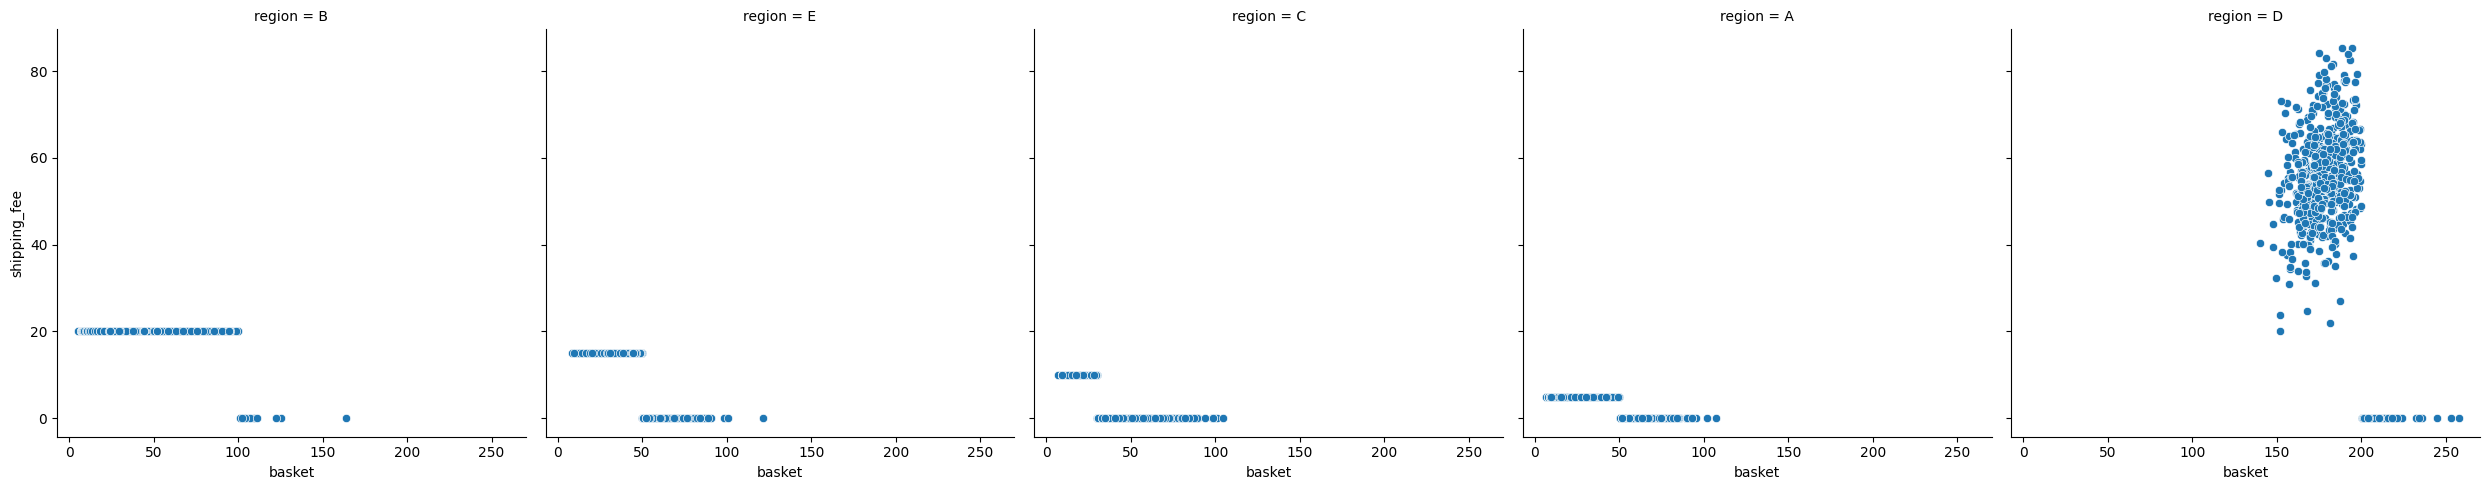

In [146]:
EDA.visualization()
  # 각 지역별 배송비와 장바구니에 담긴 상품의 금액 간 산점도
  # B region은 배송비 무료 threshold가 100인 것

In [147]:
print(
    (data_commerce.loc[
    lambda data: (data["shipping_fee"] > 0) & data["coupon"]
    ].shipping_fee > 0).any()
)
  # coupon을 받은 사람 중 배송비가 0이 아닌 사람이 있나? 있다
print(
    (data_commerce.loc[
    lambda data: data["subscriber"]
    ].shipping_fee > 0).any()
)
  # 연간 회원은 배송비가 무료인데, 해당 데이터에는 배송비 쿠폰이 적용되기 전으로 볼 수 있다
  # 실제 basket(X) 배송비 포함 상품가격을 결제한 금액이 아니라는 점에 유의한다
data_commerce.loc[
    lambda data: (~ data["coupon"]) & (~ data["subscriber"])
]
  # 쿠폰받은 사람과 구독자를 제외하고 나면 장바구니 크기와 배송비 간 상관관계가 문제가 된다
  # (장바구니 금액에는 배송비가 포함되어 있지 않다고 가정)

True
True


,age,basket,checkout,region,coupon,gender,monthly_spend,shipping_fee,subscriber,tenure
1,41.0,40.9,False,B,False,m,118.34,20.0,False,2.0
2,30.0,41.5,False,B,False,f,144.90,20.0,False,31.0
4,42.0,24.6,False,B,False,m,91.32,20.0,False,5.0
5,28.0,20.1,False,B,False,f,78.76,20.0,False,10.0
6,47.0,37.4,False,E,False,f,104.86,15.0,False,2.0
...,...,...,...,...,...,...,...,...,...,...
59994,57.0,24.5,False,B,False,f,117.28,20.0,False,5.0
59995,34.0,28.2,False,C,False,f,101.73,10.0,False,2.0
59997,40.0,24.0,False,B,False,f,112.53,20.0,False,6.0
59998,52.0,37.6,False,B,False,m,129.42,20.0,False,8.0


In [148]:
EDA.XGBoostCheckoutBasket(
    categorical_list = ["region", "gender"],
    numeric_list = ["age", "monthly_spend", "tenure"]
)

In [149]:
data_result = pd.concat([
    EDA.metricsCouponEffect(sort_by_standard = "coupon_spend", TF = True),
    EDA.metricsCouponEffect(sort_by_standard = "coupon_effect", TF = False),
    EDA.metricsCouponEffect(sort_by_standard = "effect_per_spend", TF = False)
])
data_result.drop(columns = "index", axis = 1, inplace = True)

In [150]:
data_result

,age,basket,checkout,region,coupon,gender,monthly_spend,shipping_fee,subscriber,tenure,...,coupon_effect,actual_shipping_fee,coupon_spend,effect_per_spend,sort_by,cummulative_spend,estimated_increase,estimated_checkout,ones,p_coupon
0,41.0,89.432320,False,C,True,f,322.93,-0.013526,False,38.0,...,-0.052066,-0.013526,-0.011353,4.586312,coupon_spend,-0.011353,-4.338865e-06,0.052055,1,0.000083
1,39.0,70.597084,False,C,True,f,288.64,-0.013526,False,43.0,...,0.084603,-0.013526,-0.010727,-7.886681,coupon_spend,-0.022080,2.711386e-06,0.052062,1,0.000167
2,22.0,65.104767,True,C,False,f,296.50,-0.013526,False,34.0,...,-0.194820,-0.013526,-0.009780,19.919510,coupon_spend,-0.031860,-1.352366e-05,0.052046,1,0.000250
3,28.0,56.969437,False,C,False,f,220.08,-0.013526,False,29.0,...,0.169882,-0.013526,-0.006251,-27.175923,coupon_spend,-0.038111,6.331393e-07,0.052060,1,0.000333
4,52.0,67.762306,False,C,False,f,290.49,-0.013526,False,1.0,...,0.137963,-0.013526,-0.005469,-25.228059,coupon_spend,-0.043580,1.213001e-05,0.052071,1,0.000417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,35.0,43.475433,False,B,True,m,157.28,19.999647,True,14.0,...,-0.081890,0.000000,0.000000,-inf,effect_per_spend,21319.051599,6.715772e-02,0.119217,1,0.999667
11996,35.0,33.798882,False,A,False,f,121.73,4.998890,True,15.0,...,-0.095675,0.000000,0.000000,-inf,effect_per_spend,21319.051599,6.714974e-02,0.119209,1,0.999750
11997,25.0,27.748356,False,B,False,m,97.72,20.000273,True,13.0,...,-0.006846,0.000000,0.000000,-inf,effect_per_spend,21319.051599,6.714918e-02,0.119208,1,0.999833
11998,22.0,40.043125,False,A,True,f,132.78,4.998890,True,27.0,...,-0.067863,0.000000,0.000000,-inf,effect_per_spend,21319.051599,6.714352e-02,0.119203,1,0.999917


<Axes: xlabel='cummulative_spend', ylabel='estimated_checkout'>

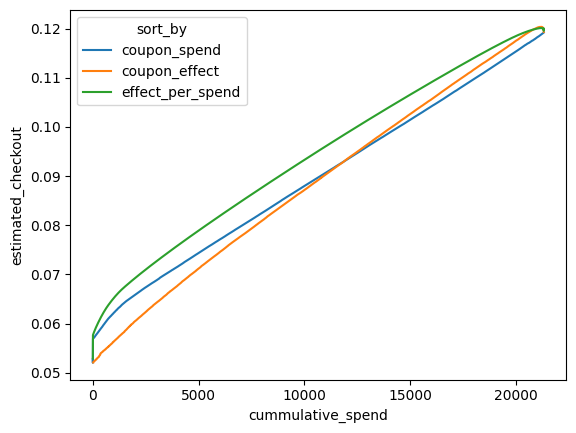

In [154]:
# 만약 배송비 쿠폰 이벤트에 5,000만 원의 예산이 있다면
# 기존 고객 중 연간회원(배송비 무료)이 아니면서 배송비 쿠폰을 보유하지 않은 사람에 대하여
# 모델 기반의 구매율 ATE을 높이기 위해 어떤 기준으로 고객들에게 배송비 쿠폰을 지급할지 결정하기 위한 플롯

sns.lineplot(
    x = "cummulative_spend",
    y = "estimated_checkout",
    hue = "sort_by",
    data = data_result,
    errorbar = None
)

In [155]:
(
    data_result[
        (data_result.cummulative_spend <= 50000) & (data_result.sort_by == "effect_per_spend") ]
          # 예산 5,000만 원 이하이면서 영업비용 대비 영업수익 증가율 추정치를 기준으로 배송비 쿠폰 지급하는 
          # 조건으로 데이터 필터링
    .nlargest(1, "cummulative_spend")
    .loc[:, ["cummulative_spend", "estimated_increase", "estimated_checkout", "p_coupon"]]
)

,cummulative_spend,estimated_increase,estimated_checkout,p_coupon
11840,21319.097567,0.067828,0.119887,0.98675


### 5.수익과 이익을 극대화하기 위한 의사결정을 하고자 하는 상황

필요한 데이터와 모형
* 예산 제약 계산에 사용되는 데이터 / 모형 / 가정
* 쿠폰 지급에 따른 이익 = 수익 - 비용 계산